In [1]:
from bounce import *
from torch.utils.data import DataLoader
loader = DataLoader(
    BouncyBallsData(),
    batch_size=512,
    drop_last=True,
    #num_workers=2,
    #persistent_workers=True,
    pin_memory=False
)

# TODO: repeat the same batch  - maybe until overfitting or something? 

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\zsomk\anaconda3\envs\torch_pl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loader = DataLoader(
    BouncyBallsDataStatic(),
    batch_size=512,
    drop_last=True,
    #num_workers=2,
    #persistent_workers=True,
    pin_memory=False
)

In [3]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl

In [4]:
class BaseModule(pl.LightningModule):
    def __init__(self, only_position=False):
        super(BaseModule, self).__init__()
        self.only_position = only_position
        self.input_size = 8
        if self.only_position:
            self.output_size = 2
        else:
            self.output_size = 4

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        # could think of scaling too.
        loss = F.mse_loss(y_hat[:, :self.output_size], y[:, :self.output_size])
        self.log('train_loss', loss.item(), on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer 

In [5]:
class MLP(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, output_size):
        
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes  = hidden_sizes
        self.output_size = output_size
        
        self.linears = []
        prev_hidden = self.input_size
        for hidden_size in self.hidden_sizes:
            self.linears.append(torch.nn.Linear(prev_hidden, hidden_size))
            prev_hidden = hidden_size
        self.linears.append(torch.nn.Linear(prev_hidden, self.output_size))

        self.linears = torch.nn.ModuleList(self.linears)
        self.relu = torch.nn.ReLU()

    
    def forward(self, x):
        for linear in self.linears[:-1]:
            x = self.relu(linear(x))
        x = self.linears[-1](x)
        return x

In [6]:
class MLP_model(BaseModule):
    def __init__(self, hidden_sizes, only_position=False):
        super(MLP_model, self).__init__(only_position)
        self.model = MLP(self.input_size, hidden_sizes, self.output_size)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class Identity(pl.LightningModule):
    def __init__(self, output_size):
        
        super(Identity, self).__init__()
        self.output_size = output_size

    def forward(self, x):
        return x[:, :self.output_size]

In [8]:
class Identity_model(BaseModule):
    def __init__(self, only_position=False):
        super(Identity_model, self).__init__(only_position)
        self.model = Identity(self.output_size)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class ConstantSpeed(pl.LightningModule):
    def __init__(self, output_size):
        
        super(ConstantSpeed, self).__init__()
        self.output_size = output_size

    def forward(self, x):
        x = x[:, :4] + torch.cat((x[:, 2:4] / 60, x[:, 2:4] * 0), dim=1)
        return x[:, :self.output_size]

In [10]:
class ConstantSpeed_model(BaseModule):
    def __init__(self, only_position=False):
        super(ConstantSpeed_model, self).__init__(only_position)
        self.model = ConstantSpeed(self.output_size)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class FreeFall(pl.LightningModule):
    def __init__(self, output_size):
        
        super(FreeFall, self).__init__()
        self.output_size = output_size

    def forward(self, x):
        x = x[:, :4] + torch.cat((x[:, 2:4] / 60, x[:, 2:3] * 0, x[:, 2:3] * 0 + 900/60), dim=1)
        return x[:, :self.output_size]


class FreeFall_model(BaseModule):
    def __init__(self, only_position=False):
        super(FreeFall_model, self).__init__(only_position)
        self.model = FreeFall(self.output_size)
    
    def forward(self, x):
        return self.model(x)

In [12]:
class Identity_MLP_model(BaseModule):
    def __init__(self, hidden_sizes, only_position=False):
        super(Identity_MLP_model, self).__init__(only_position)
        self.model = Identity(self.output_size)
        self.model2 = MLP(self.input_size, hidden_sizes, self.output_size)
    
    def forward(self, x):
        return self.model(x) + self.model2(x)

In [13]:
class ConstantSpeed_MLP_model(BaseModule):
    def __init__(self, hidden_sizes, only_position=False):
        super(ConstantSpeed_MLP_model, self).__init__(only_position)
        self.model = ConstantSpeed(self.output_size)
        self.model2 = MLP(self.input_size, hidden_sizes, self.output_size)
    
    def forward(self, x):
        return self.model(x) + self.model2(x)

In [ ]:
# convergence much slower if we keep regenerating examples.

In [18]:
models = {
    #'simple_nn_pos_only': MLP_model([1024,], True),
    #'identity_pos_only': Identity_model(True),
    #'constant_speed_pos_only': ConstantSpeed_model(True),
    #'constant_speed': ConstantSpeed_model(False),
    #'free_fall': FreeFall_model(False),
    #'identity_mlp_pos_only': Identity_MLP_model([1024,1024], True),
    #'constant_speed_mlp_pos_only': ConstantSpeed_MLP_model([1024,1024], True),
    #'constant_speed_small_pos_only': ConstantSpeed_MLP_model([8], True),
    'constant_speed_mlp_pos_only_static': ConstantSpeed_MLP_model([1024, 256], True), # 128, 32
}

In [59]:
# run this for all modes
# save the final models for analysis
# save logs with intuitive names
# finally compare them on the same test examples.

In [19]:
# could add early stopping with patience
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
early_stop_callback = EarlyStopping(monitor="train_loss", patience=1000, verbose=False, mode="min")

for model_name, model in models.items():
    # this is to handle models without parameters that do not need training
    try:
        logger = TensorBoardLogger("lightning_logs", name=model_name)
        trainer = pl.Trainer(gpus=1, max_epochs=1000,
                            gradient_clip_val=0.5,
                            callbacks=[early_stop_callback],
                            logger=logger)
                            #accumulate_grad_batches=4)

        trainer.fit(model, loader)
    except Exception as e:
        print(e)
    torch.save(model.state_dict(), f'saved_models/{model_name}.mod')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type          | Params
-----------------------------------------
0 | model  | ConstantSpeed | 0     
1 | model2 | MLP           | 272 K 
-----------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.089     Total estimated model params size (MB)


Epoch 1014: : 30it [11:20, 22.68s/it, loss=0.0119, v_num=1]
Epoch 999: : 30it [09:55, 19.84s/it, loss=0.0316, v_num=2]


In [ ]:
# run tensorboard in cmd to see the progress
tensorboard --logdir lightning_logs

In [80]:
torch.save(model.state_dict(), 'neg_err_w.mod')

In [ ]:
model.load_state_dict(torch.load('select_model.mod'))
model.eval()

In [1]:
models = {
    #'identity_pos_only': Identity_model(True),
    #'constant_speed_pos_only': ConstantSpeed_model(True),
    'constant_speed': ConstantSpeed_model(False),
    #'free_fall': FreeFall_model(False),
    #'identity_mlp_pos_only': Identity_MLP_model([1024,1024], True),
    #'constant_speed_mlp_pos_only': ConstantSpeed_MLP_model([1024,1024], True),
}

NameError: name 'ConstantSpeed_model' is not defined

In [69]:
loader = DataLoader(
    BouncyBallsData(),
    batch_size=512 * 16,
    drop_last=True,
    #num_workers=2,
    #persistent_workers=True,
    pin_memory=False
)

xs, ys = next(iter(loader))

In [70]:
# position errors

for model_name, model in models.items():
    print(model_name)
    model.load_state_dict(torch.load(f'saved_models/{model_name}.mod'))
    model.eval()

    
    ys_hat = model.to('cpu')(xs)

    loss = F.mse_loss(ys_hat[:, :2], ys[:, :2])
    print(loss)

    #errors = ((ys[:, :2] - ys_hat[:, :2]) ** 2).sum(dim=1, keepdim=True)
    #print(errors.mean())
    

simple_nn_pos_only
tensor(25207.3516, grad_fn=<MseLossBackward0>)
identity_pos_only
tensor(11.9946)
constant_speed_pos_only
tensor(0.0007)
constant_speed
tensor(0.0007)
free_fall
tensor(0.0007)
identity_mlp_pos_only
tensor(0.1275, grad_fn=<MseLossBackward0>)
constant_speed_mlp_pos_only
tensor(0.0007, grad_fn=<MseLossBackward0>)


In [ ]:
simple_nn_pos_only
tensor(44077.9609, grad_fn=<MeanBackward0>)
identity_pos_only
tensor(28.3564)
constant_speed_pos_only
tensor(0.0014)
constant_speed
tensor(0.0014)
free_fall
tensor(0.0014)
identity_mlp_pos_only
tensor(0.2419, grad_fn=<MeanBackward0>)
constant_speed_mlp_pos_only
tensor(0.2364, grad_fn=<MeanBackward0>)

In [36]:
x, y = next(iter(loader))

In [37]:
w, y_hat = model.to('cpu').forward(x)
y_loss = ((y_hat - y) ** 2).mean(dim=1, keepdim=True)
w_target = model.norm2(y_loss.detach())
w_loss = (((w_target - w) * w.shape[0]) ** 2).mean()
wy_loss = (w.detach() * y_loss).sum()
y_loss = y_loss.mean()

ValueError: too many values to unpack (expected 2)

In [ ]:
# think of unrolling predictions
# just color based on the error of 1-step prediction

In [89]:
game = BouncyBalls()
game.run()
xs = torch.Tensor(game.history)[:-1, :]
ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]
ys_hat = model.to('cpu')(xs)
errors = ((ys[:, :2] - ys_hat[:, :2]) ** 2).sum(dim=1, keepdim=True)
errors /= errors.max()
next_positions = torch.cat((ys[:, :2], errors), axis=1).detach()

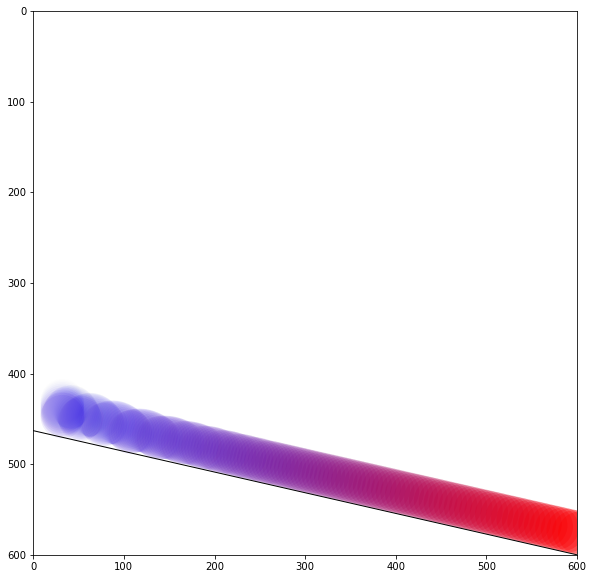

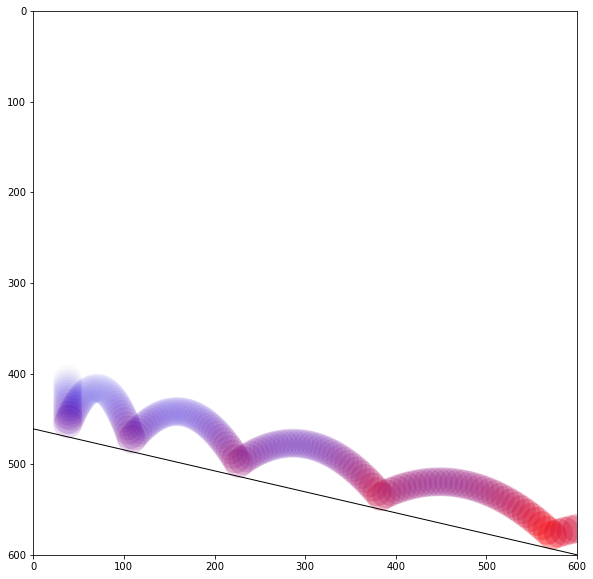

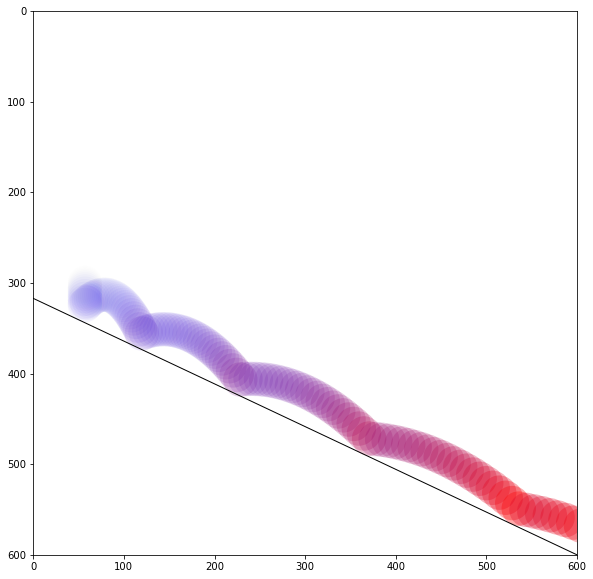

Epoch 0: : 0it [03:25, ?it/s]


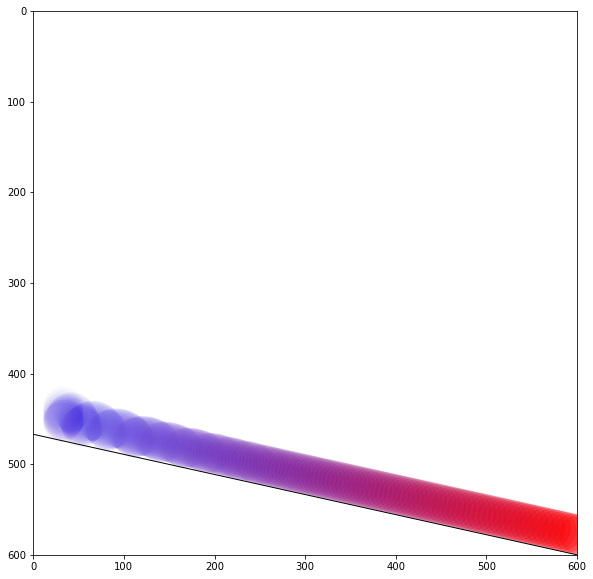

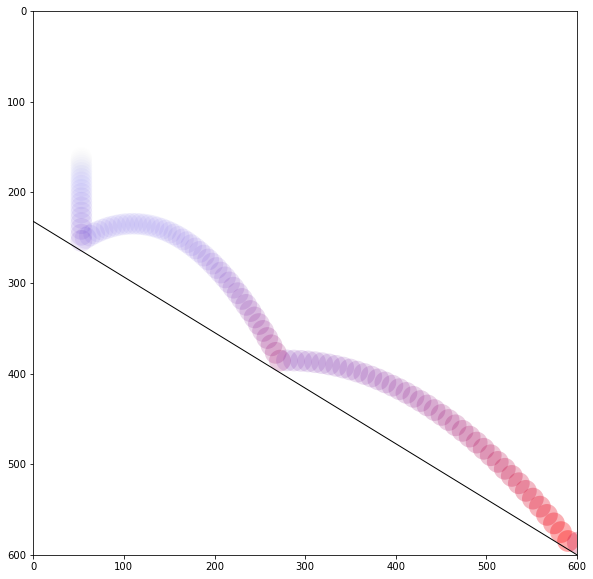

In [40]:

for _ in range(5):

    game = BouncyBalls()
    game.run()
    xs = torch.Tensor(game.history)[:-1, :]
    ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]
    ys_hat = model.to('cpu')(xs)

    errors = ((ys[:, :2] - ys_hat[:, :2]) ** 2).sum(dim=1, keepdim=True)
    errors /= errors.max()
    next_positions = torch.cat((ys[:, :2], errors), axis=1).detach()


    fig = plt.figure(figsize=(14,10))
    ax = plt.axes(xlim=(0, 600), ylim=(0, 600))
    ax.set_aspect("equal")
    ax.invert_yaxis()


    line = plt.Line2D([0, 600], [600 - game._yh, 600], linewidth=1, color='black')  # type: ignore
    ax.add_line(line)

    for x, y, e in next_positions:
        e = float(e)
        p = plt.Circle(  # type: ignore
                (x, y),
                game.parameters[1],
                facecolor=(e, 0, 1-e, e/3),
            )
        ax.add_patch(p)

    plt.show()



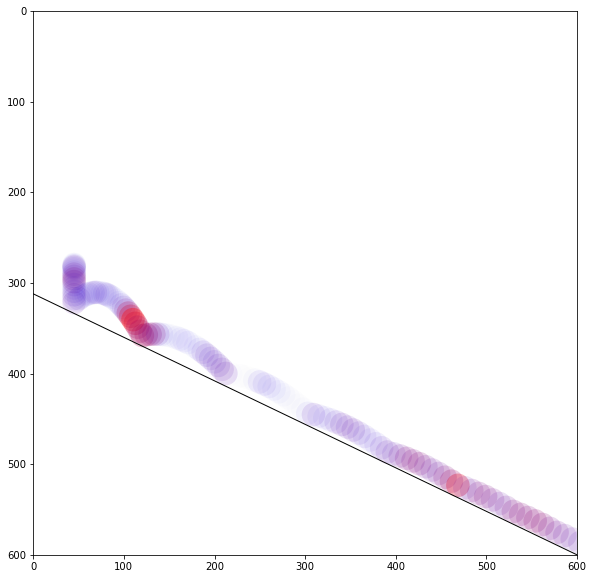

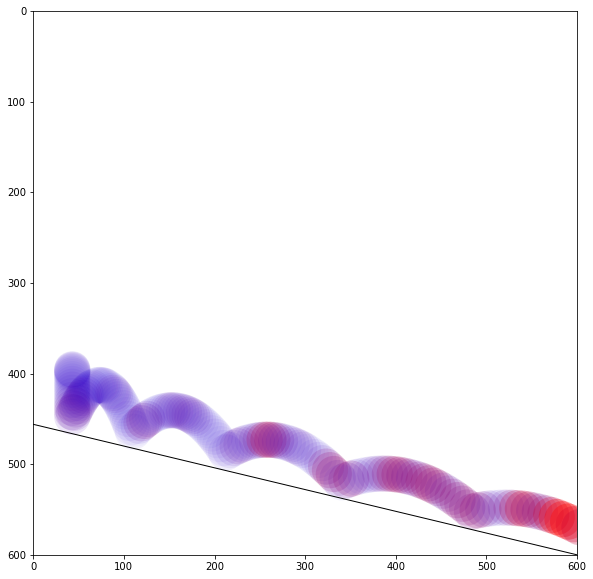

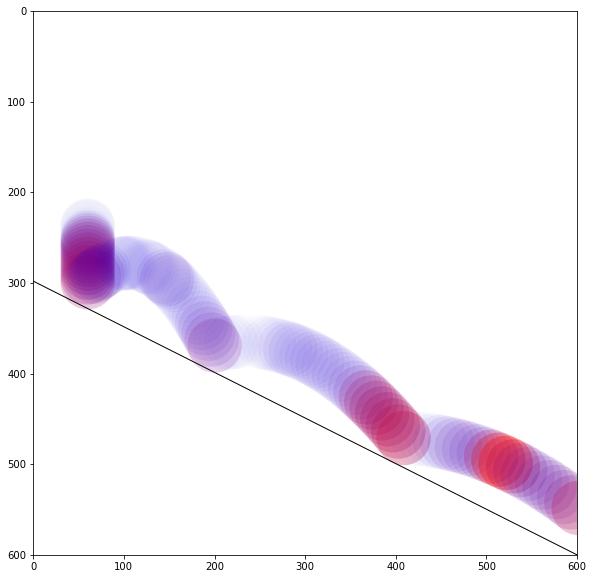

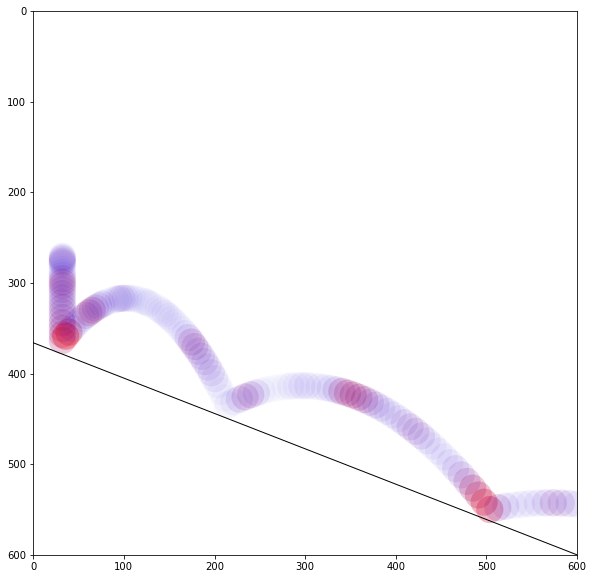

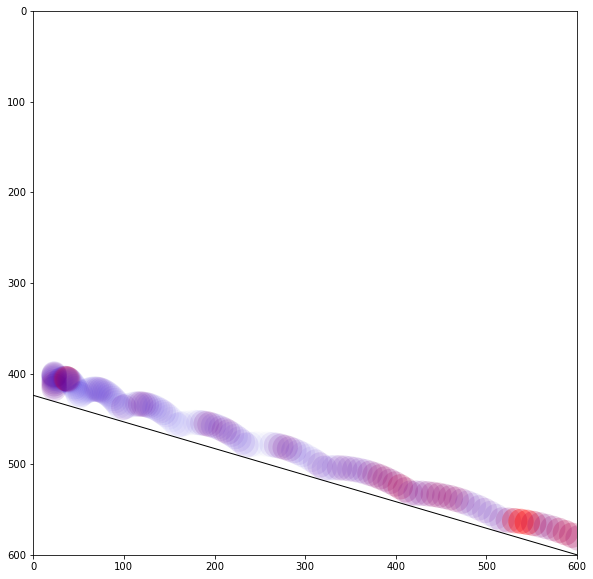

In [32]:
for _ in range(5):

    game = BouncyBalls()
    game.run()
    xs = torch.Tensor(game.history)[:-1, :]
    ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]
    ys_hat = model.to('cpu')(xs)

    errors = ((ys[:, :2] - ys_hat[:, :2]) ** 2).sum(dim=1, keepdim=True)
    errors /= errors.max()
    next_positions = torch.cat((ys[:, :2], errors), axis=1).detach()


    fig = plt.figure(figsize=(14,10))
    ax = plt.axes(xlim=(0, 600), ylim=(0, 600))
    ax.set_aspect("equal")
    ax.invert_yaxis()


    line = plt.Line2D([0, 600], [600 - game._yh, 600], linewidth=1, color='black')  # type: ignore
    ax.add_line(line)

    for x, y, e in next_positions:
        e = float(e)
        p = plt.Circle(  # type: ignore
                (x, y),
                game.parameters[1],
                facecolor=(e, 0, 1-e, e/3),
            )
        ax.add_patch(p)

    plt.show()

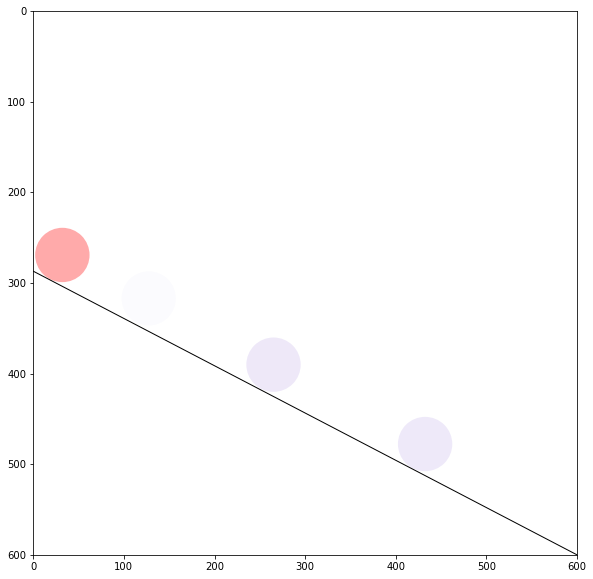

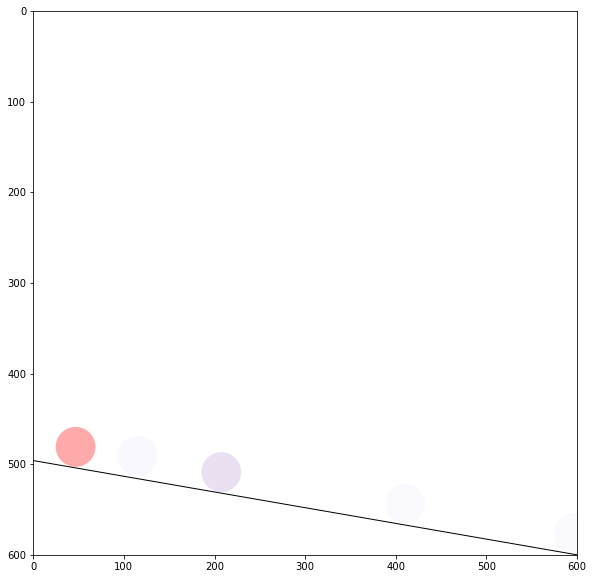

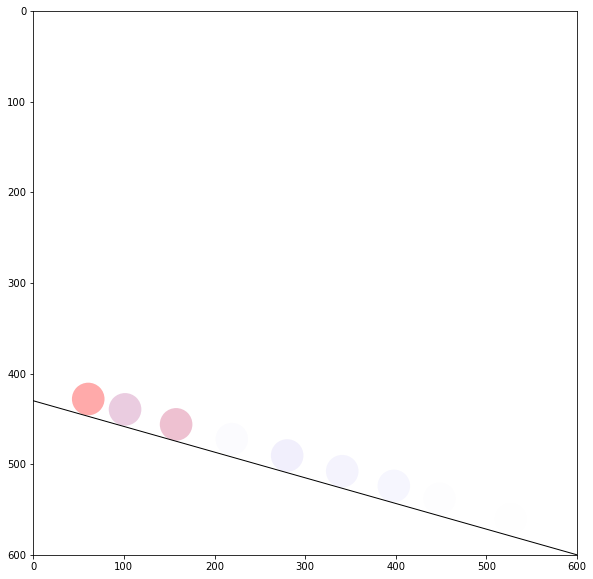

Epoch 0: : 0it [12:50, ?it/s]
Epoch 0: : 0it [07:36, ?it/s]


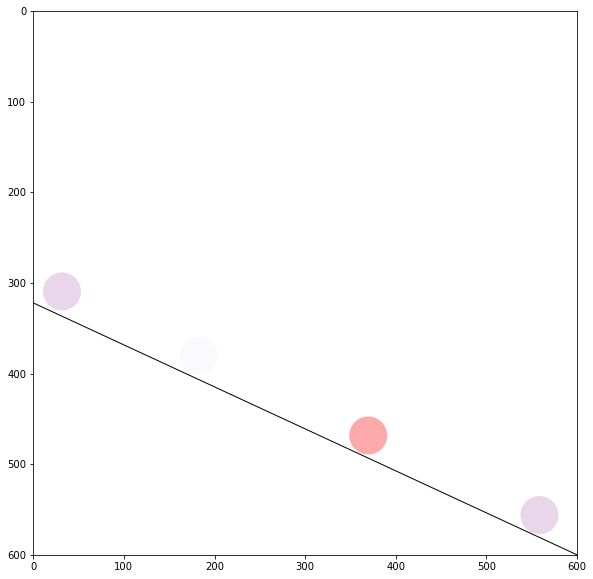

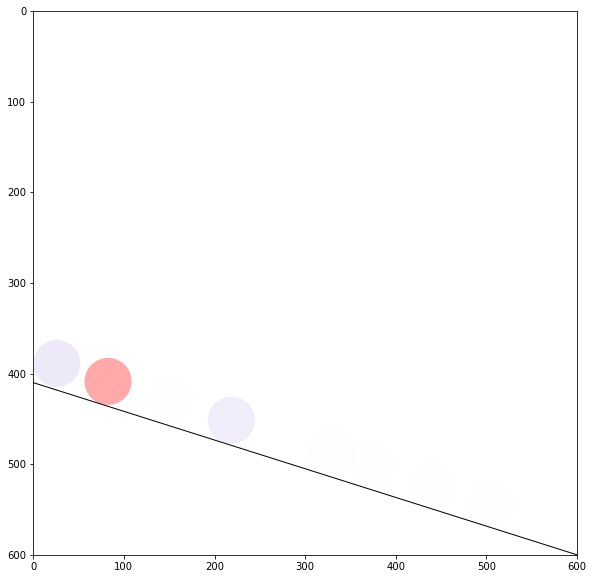

In [52]:
for _ in range(5):

    game = BouncyBalls()
    game.run()
    xs = torch.Tensor(game.history)[:-1, :]
    ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]
    ys_hat = model.to('cpu')(xs)

    errors = ((ys[:, :2] - ys_hat[:, :2]) ** 2).sum(dim=1, keepdim=True)
    errors /= errors.max()
    next_positions = torch.cat((ys[:, :2], errors), axis=1).detach()


    fig = plt.figure(figsize=(14,10))
    ax = plt.axes(xlim=(0, 600), ylim=(0, 600))
    ax.set_aspect("equal")
    ax.invert_yaxis()


    line = plt.Line2D([0, 600], [600 - game._yh, 600], linewidth=1, color='black')  # type: ignore
    ax.add_line(line)

    for x, y, e in next_positions:
        e = float(e)
        p = plt.Circle(  # type: ignore
                (x, y),
                game.parameters[1],
                facecolor=(e, 0, 1-e, e/3),
            )
        ax.add_patch(p)

    plt.show()

In [64]:
game = BouncyBalls()
game.run()
xs = torch.Tensor(game.history)[:-1, :]
ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]

In [66]:
errors = (ys[:, 2:] - xs[:, 2:4])

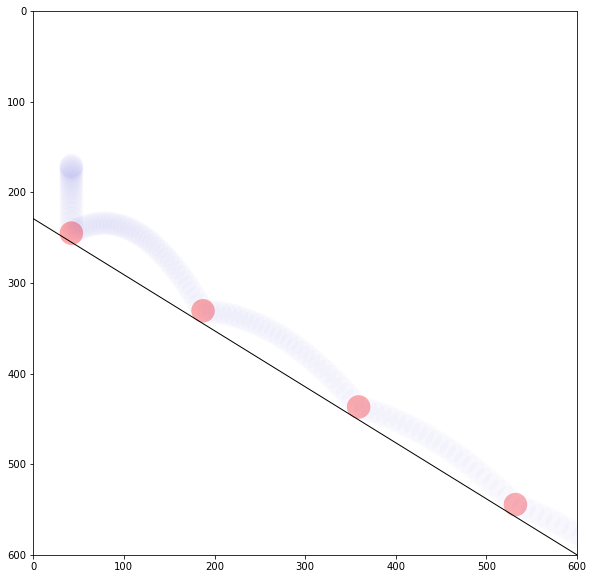

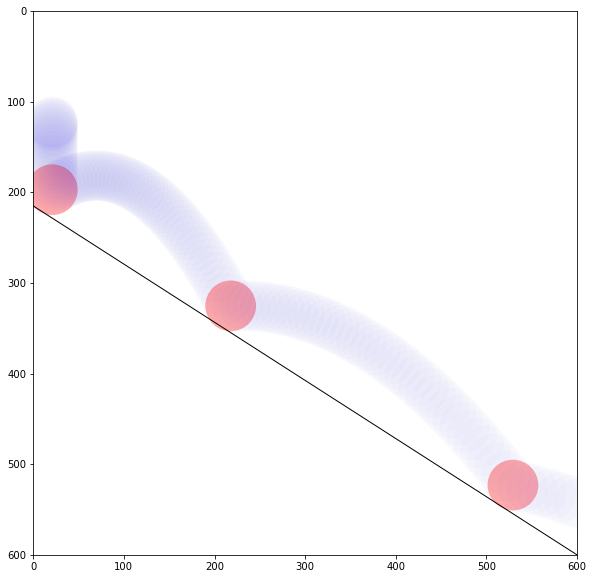

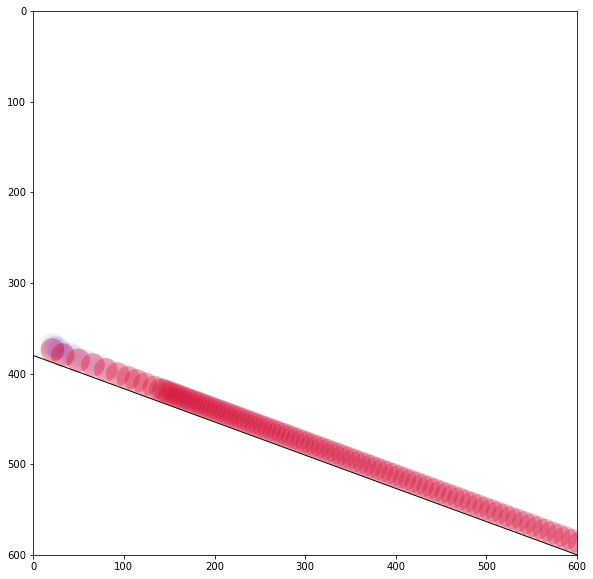

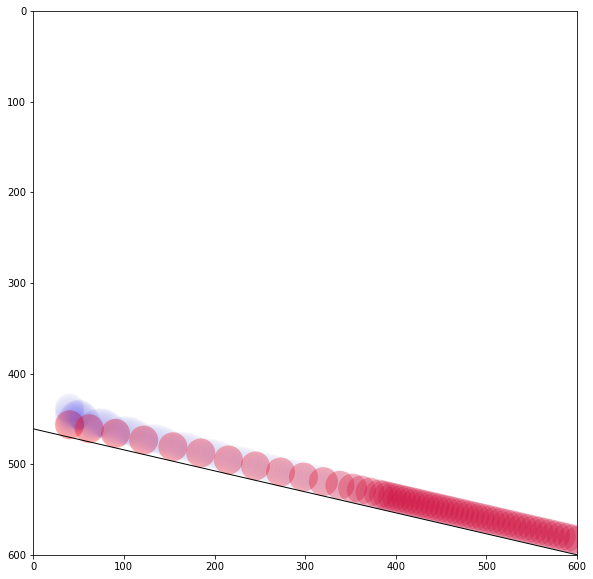

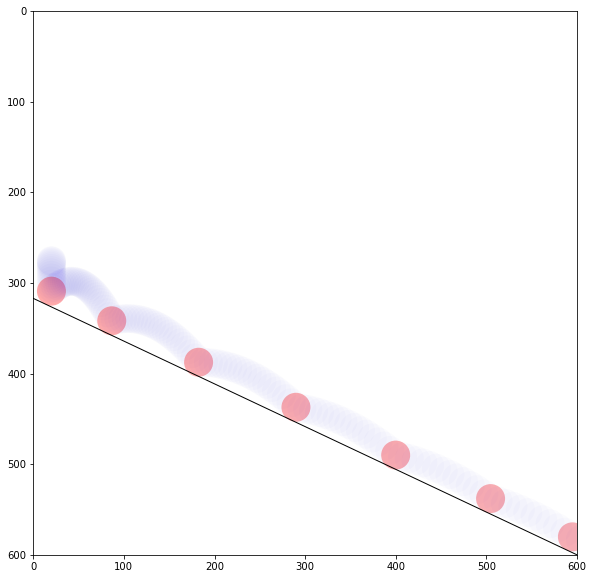

In [25]:
# speed error.
import numpy as np
import matplotlib.pyplot as plt

for _ in range(5):

    game = BouncyBalls()
    game.run()
    xs = torch.Tensor(game.history)[:-1, :]
    ys = torch.Tensor(game.history)[:, :4].roll(-1, dims=0)[:-1, :]
    ys_hat = model.to('cpu')(xs)

    errors = ((ys[:, 2:] - ys_hat[:, 2:]) ** 2).sum(dim=1, keepdim=True)
    errors = np.log(errors + 1e-8)
    errors -= errors.min()
    errors /= errors.max()
    errors = 0.05 + 0.95 * errors
    next_positions = torch.cat((ys[:, :2], errors), axis=1).detach()


    fig = plt.figure(figsize=(14,10))
    ax = plt.axes(xlim=(0, 600), ylim=(0, 600))
    ax.set_aspect("equal")
    ax.invert_yaxis()


    line = plt.Line2D([0, 600], [600 - game._yh, 600], linewidth=1, color='black')  # type: ignore
    ax.add_line(line)

    for x, y, e in next_positions:
        e = float(e)
        p = plt.Circle(  # type: ignore
                (x, y),
                game.parameters[1],
                facecolor=(e, 0, 1-e, e/3),
            )
        ax.add_patch(p)

    plt.show()

In [ ]:
class MLP_ew(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, hidden_sizes2, output_size):
        
        super(MLP_ew, self).__init__()
        self.input_size = input_size
        self.hidden_sizes  = hidden_sizes
        self.hidden_sizes2  = hidden_sizes2
        self.output_size = output_size
        
        self.mlp1 = MLP(self.input_size, self.hidden_sizes, 1)
        self.norm = torch.nn.BatchNorm1d(1)

        self.mlp2 = MLP(self.input_size, self.hidden_sizes2, self.output_size)

        self.sigmoid = torch.nn.Sigmoid()
        self.norm2 = torch.nn.BatchNorm1d(1) #(self.output_size)

    
    def forward(self, x):
        weight = self.sigmoid(self.norm(self.mlp1(x)))

        output = self.mlp2(x)

        return weight, output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        w, y_hat = self.forward(x)
        y_loss = ((y_hat - y) ** 2).mean(dim=1, keepdim=True)
        # can be weighting the difficult or easy examples.
        w_target = self.sigmoid(1 * self.norm2(y_loss.detach()))
        w_loss = ((w_target - w) ** 2).mean()
        wy_loss = (w.detach() * y_loss).mean()
        y_loss = y_loss.mean()

        self.log('train_loss', y_loss.item(), on_epoch=True, on_step=False)
        self.log('weight_loss', w_loss.item(), on_epoch=True, on_step=False)
        self.log('weighted_loss', wy_loss.item(), on_epoch=True, on_step=False)

        return wy_loss + w_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer 

class MLP_ew_sm(pl.LightningModule):
    def __init__(self, input_size, hidden_sizes, hidden_sizes2, output_size):
        
        super(MLP_ew_sm, self).__init__()
        self.input_size = input_size
        self.hidden_sizes  = hidden_sizes
        self.hidden_sizes2  = hidden_sizes2
        self.output_size = output_size
        
        self.mlp1 = MLP(self.input_size, self.hidden_sizes, 1)
        self.norm = torch.nn.Softmax(dim=0)

        self.mlp2 = MLP(self.input_size, self.hidden_sizes2, self.output_size)

        self.sigmoid = torch.nn.Sigmoid()
        self.norm2 = torch.nn.Softmax(dim=0) #(self.output_size)

    
    def forward(self, x):
        weight = self.norm(self.mlp1(x))

        output = self.mlp2(x)

        return weight, output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        w, y_hat = self.forward(x)
        # this isn't the most natural way to weight the errors
        y_loss = ((y_hat - y) ** 2).mean(dim=1, keepdim=True)
        # can be weighting the difficult or easy examples.
        w_target = self.norm2(1 - y_loss.detach())
        w_loss = (((w_target - w) * w.shape[0]) ** 2).mean()
        wy_loss = (w.detach() * y_loss).sum()
        y_loss = y_loss.mean()

        self.log('train_loss', y_loss.item(), on_epoch=True, on_step=False)
        self.log('weight_loss', w_loss.item(), on_epoch=True, on_step=False)
        self.log('weighted_loss', wy_loss.item(), on_epoch=True, on_step=False)

        return wy_loss + w_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer 

<AxesSubplot:>

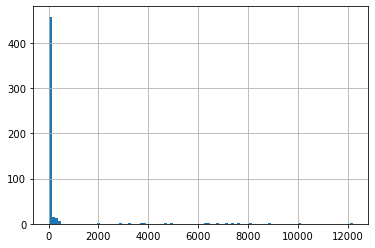

In [140]:
pd.Series(wy_loss[:, 0].detach().numpy()).hist(bins=100)

<AxesSubplot:>

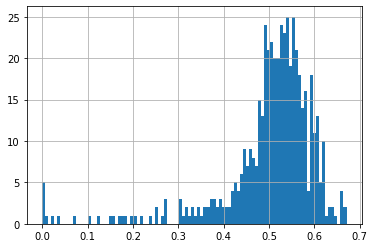

In [141]:
pd.Series(w[:, 0].detach().numpy()).hist(bins=100)

In [142]:
df = pd.DataFrame([pd.Series(y_loss.detach().numpy()[:,0]), pd.Series(w.detach().numpy()[:,0])]).T
df.columns = ['y_loss', 'w']
df.corr()

,y_loss,w
y_loss,1.000000,-0.477533
w,-0.477533,1.000000


In [143]:
df[df['w'] < 0.1].y_loss.mean()

19129.09375

In [144]:
df[df['w'] > 0.5].y_loss.mean()

145.11422729492188

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

<AxesSubplot:>

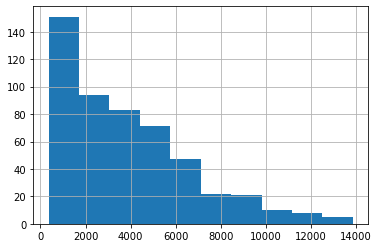

In [27]:
# before training
import pandas as pd
pd.Series(y_loss[:, 0].detach().numpy()).hist()

<AxesSubplot:>

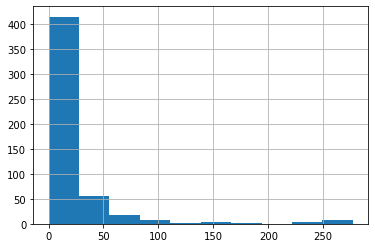

In [23]:
# after training
import pandas as pd
pd.Series(y_loss[:, 0].detach().numpy()).hist()

<AxesSubplot:>

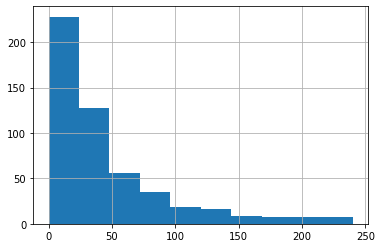

In [35]:
# g = 0
import pandas as pd
pd.Series(y_loss[:, 0].detach().numpy()).hist()

<AxesSubplot:>

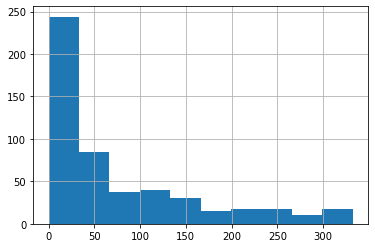

In [40]:
# training only g
import pandas as pd
pd.Series(y_loss[:, 0].detach().numpy()).hist()

<AxesSubplot:>

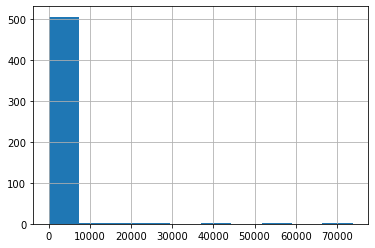

In [47]:
# training choice
import pandas as pd
pd.Series(y_loss[:, 0].detach().numpy()).hist()

In [ ]:
# add a callback to save the model
# add proper names to runs instead of version...

In [ ]:
# basic model: v10 (around 1200 is where it stops, 6.5k iterations)
# residual model: v11 (around 1200 is where it stops, 2k iterations)
# v12 small
# v13 only g
# v14: choice